In [1]:
import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import collections
import os

# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12

# keras                                           -OVO JE DODATO
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation

from tensorflow.keras.optimizers import SGD

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images 
    

In [3]:
#procesiranje slika
def rgb2gray(img_rgb):
    img_gray = np.ndarray((img_rgb.shape[0], img_rgb.shape[1]))  # zauzimanje memorije za sliku (nema trece dimenzije)
    img_gray = 0.21*img_rgb[:, :, 0] + 0.72*img_rgb[:, :, 1] + 0.07*img_rgb[:, :, 2]
    img_gray = img_gray.astype('uint8')  # u prethodnom koraku smo mnozili sa float, pa sada moramo da vratimo u [0,255] opseg
    return img_gray


def treshold(image):
    treshold_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 5)
    return treshold_image

def opening(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    eroded_image = cv2.erode(image, kernel, iterations=1)
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=1)
    return dilated_image

def closing(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.dilate(image, kernel, iterations=3)
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
    return eroded_image


def preparing_images(images):
    preparing_images = []
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #prvo prebacivanje u RGB iz BGR
        image = rgb2gray(image) #radjenje grayscale
        image = opening(image)
        #image = closing(image)
        #image = opening(image)
        #image = treshold(image)
        #image = closing(image)
        preparing_images.append(image)
        
    return preparing_images

In [4]:
#detekcija knjiga
def detection_regions(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def choosing_contours(contours):
    contours_book = [] #ovde ce biti samo konture koje pripadaju knjigama
    for contour in contours: # za svaku konturu
        center, size, angle = cv2.minAreaRect(contour) # pronadji pravougaonik minimalne povrsine koji ce obuhvatiti celu konturu
        width, height = size
        if (width > 20 and width < 100 and height > 200 and height < 1000) or (height > 20 and height < 100 and width > 200 and width < 1000): # uslov da kontura pripada bar-kodu
            contours_book.append(contour) # ova kontura pripada bar-kodu
    return contours_book


189
140


'\nplt.imshow(closed)\n\nimg2 = img.copy()\nprint(len(cnts))\n#cv2.drawContours(img2, cnts, -1, (0, 255, 0), 4)\nkonture = choosing_contours(cnts)\nprint(len(konture))\n\n#cv2.drawContours(img2, konture, -1, (0, 255, 0), 4)\ncv2.drawContours(img2, [konture[0]], -1, (255, 0, 0), 4)\ncv2.drawContours(img2, [konture[1]], -1, (0, 255, 0), 4)\n#cv2.drawContours(img2, [konture[2]], -1, (0, 0, 255), 4)\nplt.imshow(img2)'

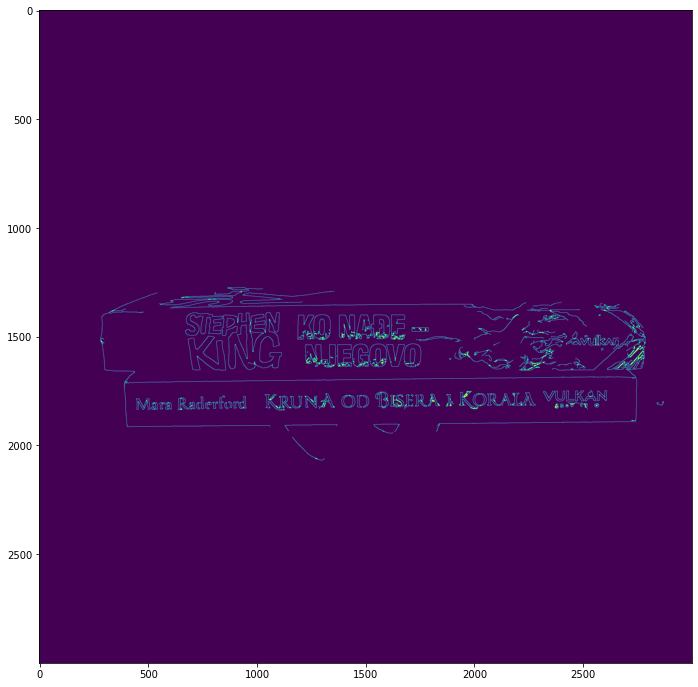

In [9]:
#glavna funkcija (main)
#images = load_images_from_folder("skup_podataka")
img = cv2.imread('skup_podataka/srednjiKval.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
images = [img]
images = preparing_images(images)
plt.imshow(images[0], 'gray')

"""3
img2 = img.copy()
konture = detection_regions(images[0])
print(len(konture))
konture = choosing_contours(konture)
print(len(konture))
cv2.drawContours(img2, konture, -1, (0, 255, 0), 4)
plt.imshow(img2)
"""

#imgg = closing(images[0])
gray = cv2.GaussianBlur(images[0], (3, 3), 1)
edged = cv2.Canny(gray, 10, 250)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
import math
cdst = np.copy(img)
cdstP = np.copy(cdst)

lines = cv2.HoughLines(edged, 1, np.pi / 180, 150, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
print(len(lines))

linesP = cv2.HoughLinesP(edged, 1, np.pi / 180, 50, None, 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
print(len(linesP))
plt.imshow(cdst)
#plt.imshow(cdstP)
    
(cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
total = 0
plt.imshow(closed)

"""2
for c in cnts:
  # approximate the contour
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.01 * peri, True)

  # if the approximated contour has four points, then assume that the
  # contour is a book -- a book is a rectangle and thus has four vertices
  if len(approx) == 4:
    cv2.drawContours(img, [approx], -1, (0, 255, 0), 4)
    total += 1
print ("I found {0} books in that image".format(total))
plt.imshow(img)
"""
"""
plt.imshow(closed)

img2 = img.copy()
print(len(cnts))
#cv2.drawContours(img2, cnts, -1, (0, 255, 0), 4)
konture = choosing_contours(cnts)
print(len(konture))

#cv2.drawContours(img2, konture, -1, (0, 255, 0), 4)
cv2.drawContours(img2, [konture[0]], -1, (255, 0, 0), 4)
cv2.drawContours(img2, [konture[1]], -1, (0, 255, 0), 4)
#cv2.drawContours(img2, [konture[2]], -1, (0, 0, 255), 4)
plt.imshow(img2)"""
